# Who's the biggest tax evader?

#### Imports:

In [1]:
import plotly.plotly as py
import pandas as pd
import pycountry
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

## 1. Data cleaning and preprocessing

### 1.1 Loading data

The goal is to better understand how different socio-economic factors are linked with tax evasion occurrences in different countries. To help us visualize this, we will use choropleth world maps to display information.

We have observed in our datasets that certain countries are referred to under different names, for instance "China" vs "People's Republic of China". Also, since we are considering data that spans over multiple years, we run into issues with countries that have changed their names, for instance Swaziland becoming Eswatini. Thus, we decided to use [ISO 3166-1](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) three-letter country codes as the identifiers for countries, as these values are consistent for all countries and through the years. From the Plotly choropleth map [documentation](https://plot.ly/python/choropleth-maps/#world-choropleth-map), we got a list of ISO country codes and country names. We choose to complete this dataset ourselves manually, when we come across new ways of writing country names. We load the dataset of country codes as a Pandas `DataFrame`:

In [2]:
# Load country codes
df_country_codes = pd.read_csv('data/countries_codes.csv', low_memory=False).set_index('COUNTRY')

We load the Panamas Papers, UN and World Bank datasets into Pandas `DataFrame`s:

In [3]:
# Load datasets
## Load panama papers datasets
pp_edges = pd.read_csv('data/panama_papers/panama_papers.edges.csv', low_memory=False)
pp_nodes_address = pd.read_csv('data/panama_papers/panama_papers.nodes.address.csv', low_memory=False)
pp_nodes_entity = pd.read_csv('data/panama_papers/panama_papers.nodes.entity.csv', low_memory=False)
pp_nodes_intermediary = pd.read_csv('data/panama_papers/panama_papers.nodes.intermediary.csv', low_memory=False)
pp_nodes_officer = pd.read_csv('data/panama_papers/panama_papers.nodes.officer.csv', low_memory=False)
## Load UN datasets
un_hdi_components_2014 = pd.read_csv('data/un/hdi_components.csv', low_memory=False)
un_gdp_per_capita = pd.read_csv('data/un/gdp_per_capita.csv', low_memory=False)
un_gdp_per_capita_ppp = pd.read_csv('data/un/gdp_per_capita_PPP.csv', low_memory=False)
## Load world bank datasets
wb_gini = pd.read_csv('data/world_bank/gini_index.csv', low_memory=False)
wb_income_share_20_per = pd.read_csv('data/world_bank/income_share_20_per.csv', low_memory=False)
wb_population_total = pd.read_csv('data/world_bank/population_total.csv', low_memory=False)
wb_population_2014 = wb_population_total[['Country Code', '2014']]

### 1.2 Examining data

We look at a few of the datasets, to see what sort of preprocessing and cleaning we will have to do.

#### UN: GDP per capita

In [4]:
un_gdp_per_capita.head()

,Country,Year,Item,Value
0,Afghanistan,2016,Gross Domestic Product (GDP),583.882867
1,Afghanistan,2015,Gross Domestic Product (GDP),610.854517
2,Afghanistan,2014,Gross Domestic Product (GDP),651.158326
3,Afghanistan,2013,Gross Domestic Product (GDP),681.033974
4,Afghanistan,2012,Gross Domestic Product (GDP),694.885886


#### UN: HDI components (2014)

In [5]:
un_hdi_components_2014.head()

,HDI rank,Country,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank
0,1,Norway,0.944,81.6,17.5,12.6,64992,5
1,2,Australia,0.935,82.4,20.2,13,42261,17
2,3,Switzerland,0.93,83,15.8,12.8,56431,6
3,4,Denmark,0.923,80.2,18.7,12.7,44025,11
4,5,Netherlands,0.922,81.6,17.9,11.9,45435,9


#### World Bank: Gini coefficient index

In [6]:
wb_gini.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### World Bank: Income share top 20%

In [7]:
wb_income_share_20_per.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,48.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,39.0,NaN,NaN,NaN,37.8,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Panama Papers: addresses

In [8]:
pp_nodes_address.head()

,node_id,name,address,country_codes,countries,sourceID,valid_until,note
0,14000001,NaN,-\t27 ROSEWOOD DRIVE #16-19 SINGAPORE 737920,SGP,Singapore,Panama Papers,The Panama Papers data is current through 2015,NaN
1,14000002,NaN,"""Almaly Village"" v.5, Almaty Kazakhstan",KAZ,Kazakhstan,Panama Papers,The Panama Papers data is current through 2015,NaN
2,14000003,NaN,"""Cantonia"" South Road St Georges Hill Weybridg...",GBR,United Kingdom,Panama Papers,The Panama Papers data is current through 2015,NaN
3,14000004,NaN,"""CAY-OS"" NEW ROAD; ST.SAMPSON; GUERNSEY; CHANN...",GGY,Guernsey,Panama Papers,The Panama Papers data is current through 2015,NaN
4,14000005,NaN,"""Chirag"" Plot No 652; Mwamba Road; Kizingo; Mo...",KEN,Kenya,Panama Papers,The Panama Papers data is current through 2015,NaN


We see that neither of the two displayed UN datasets have a `Country Code` column. Fortunately, we are able to map `Country Name` values to their corresponding `Country Code` values. This will allow us to join `DataFrame`s later on, when performing analyses on socio-economic development factors.

We also observe that there are many NaN values in the Gini coefficient index dataset and the income share top 20% dataset. This is because these values are not measured annually in every country. We will solve this problem by taking the most recent value since 2000, for each of these datasets. This allows us to have the most accurate recent data possible.

#### Country location
To make it easier to draw our data, we also load a data of countries capital location (Longitude and Latitude).

In [9]:
countries_location = pd.read_csv('data/countries_latitude_longitude.csv')
countries_location = countries_location[['Alpha-3 code', 'Latitude (average)', 'Longitude (average)']]
countries_location = countries_location.rename(columns={'Alpha-3 code': 'Code', 'Latitude (average)': 'lat', 
                                                        'Longitude (average)': 'long'})

### 1.3 Data cleaning

***Select most recent statistics:***

For the Gini coefficient index and income share top 20% datasets, we are going to take the most recent value since 2000.

In [10]:
# We only consider statistics that date from 2000 onwards
years_to_drop = list(map(str, np.arange(1960, 2000)))
wb_gini = wb_gini.drop(columns=years_to_drop)
wb_income_share_20_per = wb_income_share_20_per.drop(columns=years_to_drop)

In [11]:
# We select the rightmost value (most recent) for each row
gini_values = wb_gini.stack().groupby(level=0).last().reindex(wb_gini.index)

# Only select valid values and label other values as NaN
wb_gini['Gini'] = pd.to_numeric(gini_values, errors='coerce')

# Only select relevant columns
wb_gini = wb_gini[['Country Name', 'Country Code', 'Gini']]

In [12]:
# We select the rightmost value (most recent) for each row
income_share_20_per_values = wb_income_share_20_per.stack().groupby(level=0).last().reindex(wb_income_share_20_per.index)

# Only select valid values and label other values as NaN
wb_income_share_20_per['Income Share'] = pd.to_numeric(income_share_20_per_values, errors='coerce')

# Only select relevant columns
wb_income_share_20_per = wb_income_share_20_per[['Country Name', 'Country Code', 'Income Share']]

***Add country codes to UN datasets:***

In order to display the values on maps, we need the UN datasets to contain country codes. We will perform a join on each of the UN datasets with the country codes dataset, `df_country_codes`. We will attempt to automate this process, before considering any exceptions:

In [13]:
# Join UN datasets with country codes DataFrame
un_hdi_components_2014 = un_hdi_components_2014.join(df_country_codes, on='Country')
un_gdp_per_capita = un_gdp_per_capita.join(df_country_codes, on='Country')
un_gdp_per_capita_ppp = un_gdp_per_capita_ppp.join(df_country_codes, on='Country')

We remove any parts of a country name that contain parentheses, for instance "Iran (Islamic Republic of)" becomes "Iran":

In [14]:
# List of UN DataFrames
un_dfs = [un_hdi_components_2014, un_gdp_per_capita, un_gdp_per_capita_ppp]

# Define dictionary containing pairs (country name: ISO country code)
countries = dict()

for country in pycountry.countries:
    countries[country.name] = country.alpha_3  

for df in un_dfs:
    nan_values = df['CODE'].isna()
    input_countries = list(df[nan_values]['Country'].values)
        
    codes = []
    for country in input_countries:
        if country in countries:
            codes.append(countries.get(country))
        else:        
            accepted = []
            str_country = str(country)
            # check if string contains either common or official country name
            for p_country in pycountry.countries:
                if p_country.name in str_country or (hasattr(p_country, 'common_name') and p_country.common_name in str_country):
                    accepted.append(p_country.alpha_3)
            if len(accepted) == 1:
                codes.append(accepted[0])
            else:
                codes.append(None)

    df.loc[nan_values, 'CODE'] = codes
    # Remove rows that were not found
    df = df[df['CODE'].notnull()]

***Remove N/A***

In [15]:
un_hdi_components_2014 = un_hdi_components_2014[un_hdi_components_2014['Human Development Index (HDI)'] != '..']
un_hdi_components_2014['Human Development Index (HDI)'] = un_hdi_components_2014['Human Development Index (HDI)'].astype('float')

/Users/Timothy/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [16]:
wb_gini = wb_gini.dropna()

In [17]:
wb_income_share_20_per = wb_income_share_20_per.dropna()

### 1.4 Data processing

We start by counting the number of intermediaries, officers and entities per country. This will give us a brief overview of which countries were involved and how they were involved. It will also help us find where to look to find additional interesting information.

***Number of Panama Papers references for intermediaries per country:***

In [18]:
pp_intermediary_country = pp_nodes_intermediary.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_intermediary_country = pp_intermediary_country.sort_values('counts', ascending=False)
pp_intermediary_country.head(5)

,country_codes,countries,counts
91,HKG,Hong Kong,2202
75,GBR,United Kingdom,1367
28,CHE,Switzerland,1218
217,USA,United States,603
161,PAN,Panama,552


***Number of Panama Papers references for officers per country:***

In [19]:
pp_officer_country = pp_nodes_officer.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_officer_country = pp_officer_country.sort_values('counts', ascending=False)
pp_officer_country.head(5)

,country_codes,countries,counts
33,CHN,China,24635
75,HKG,Hong Kong,13362
192,VGB,British Virgin Islands,11231
90,JEY,Jersey,6892
142,PAN,Panama,5069


***Number of Panama Papers references for entities per country:***

In [20]:
pp_entity_country = pp_nodes_entity.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_entity_country = pp_entity_country.sort_values('counts', ascending=False)
pp_entity_country.head(5)

,country_codes,countries,counts
59,HKG,Hong Kong,37911
27,CHE,Switzerland,37911
114,PAN,Panama,15811
73,JEY,Jersey,14331
89,LUX,Luxembourg,10840


***Total Number of Panama Papers references per country:***

Since one of our major interests is to study the distribution of Panama Papers references per country, we create a dataset containing country codes and the number of occurrences of that country across the datasets, merging `pp_intermediary_country`, `pp_officer_country`, `pp_entity_country`

In [21]:
# Merge all 3 tables
pp_total_country = pp_intermediary_country.merge(pp_entity_country, left_on='country_codes', right_on='country_codes').merge(pp_officer_country, left_on='country_codes', right_on='country_codes')
# Merge it with country location to make it easier to plot
pp_total_country = pp_total_country.merge(countries_location,left_on='country_codes',right_on='Code')
# Sum the diferent counts
pp_total_country['total'] = pp_total_country['counts_x'] + pp_total_country['counts_y'] + pp_total_country['counts']
pp_total_country = pp_total_country[['country_codes', 'countries', 'total', 'lat','long']]
# Display top 5 table
pp_total_country[['country_codes','countries','total']].sort_values('total', ascending=False).head(5)

,country_codes,countries,total
0,HKG,Hong Kong,53475
2,CHE,Switzerland,43397
10,CHN,China,28101
4,PAN,Panama,21432
1,GBR,United Kingdom,15900


***Number of Panama Papers references with respect to population size:***

Knowing the number of appearances of each country in the addresses leaked in Panama Papers is not very useful; some countries have a much bigger population and will therefore be over-represented. We normalize the number of occurrences by population size using the following formula:
$$ count_{1000} = \frac{nb \, occurrences}{population_{2014}} $$

We also normalize it by the percentage of income share held by the top 20% using the following formula:
$$ count_{inc_{20}} = {nb \, occurrences} \cdot {percentage_{inc_{20}}} $$

In [22]:
def normalize(df, value_col):
    df_normalized = df.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')
    df_normalized = df_normalized.merge(wb_income_share_20_per, left_on='country_codes', right_on='Country Code')
    df_normalized['counts_normalized_population'] = 1000 * df_normalized[value_col] / df_normalized['2014']
    df_normalized['counts_normalized_income_share'] = df_normalized[value_col] * df_normalized['Income Share'] / 100
    return df_normalized

In [23]:
pp_intermediary_country_normalized = normalize(pp_intermediary_country, 'counts')
pp_officer_country_normalized = normalize(pp_officer_country, 'counts')
pp_entity_country_normalized = normalize(pp_entity_country, 'counts')
pp_total_country_normalized = normalize(pp_total_country, 'total')

***Number of Panama Papers references for intermediaries per country normalized by population:***

In [24]:
pp_intermediary_country_normalized[['countries', 'counts_normalized_population']].sort_values('counts_normalized_population', ascending=False).head(5)

,countries,counts_normalized_population
6,Luxembourg,0.715417
1,Switzerland,0.148742
3,Panama,0.141394
29,Malta,0.098951
16,Cyprus,0.093725


***Number of Panama Papers references for intermediaries per country normalized by income share:***

In [25]:
pp_intermediary_country_normalized[['countries', 'counts_normalized_income_share']].sort_values('counts_normalized_income_share', ascending=False).head(5)

,countries,counts_normalized_income_share
0,United Kingdom,555.002
1,Switzerland,489.636
3,Panama,302.496
2,United States,282.807
4,Guatemala,236.376


***Number of Panama Papers references for officers per country normalized by population:***

In [26]:
pp_officer_country_normalized[['countries', 'counts_normalized_population']].sort_values('counts_normalized_population', ascending=False).head(5)

,countries,counts_normalized_population
11,Seychelles,18.673584
10,Luxembourg,3.136690
6,Cyprus,2.329236
29,Vanuatu,2.136372
37,Samoa,1.752561


***Number of Panama Papers references for officers per country normalized by income share:***

In [27]:
pp_officer_country_normalized[['countries', 'counts_normalized_income_share']].sort_values('counts_normalized_income_share', ascending=False).head(5)

,countries,counts_normalized_income_share
0,China,11800.165
1,Panama,2777.812
2,United Kingdom,1995.084
4,Russia,1865.907
3,Switzerland,1715.736


***Number of Panama Papers references for entities per country normalized by population:***

In [28]:
pp_entity_country_normalized[['countries', 'counts_normalized_population']].sort_values('counts_normalized_population', ascending=False).head(5)

,countries,counts_normalized_population
2,Luxembourg,19.485223
11,Samoa,8.388372
22,Seychelles,7.476001
0,Switzerland,4.629701
1,Panama,4.049963


***Number of Panama Papers references for entities per country normalized by income share:***

In [29]:
pp_entity_country_normalized[['countries', 'counts_normalized_income_share']].sort_values('counts_normalized_income_share', ascending=False).head(5)

,countries,counts_normalized_income_share
0,Switzerland,15240.222
1,Panama,8664.428
2,Luxembourg,4444.400
3,United Kingdom,3905.314
4,Uruguay,2251.854


***Total Number of Panama Papers references per country normalized by population:***

In [30]:
pp_total_country_normalized[['countries', 'counts_normalized_population']].sort_values('counts_normalized_population', ascending=False).head(5)

,countries,counts_normalized_population
62,Seychelles,26.215261
6,Luxembourg,23.337330
16,Cyprus,5.558405
3,Panama,5.489774
1,Switzerland,5.299653


***Total Number of Panama Papers references per country normalized by income share:***

In [31]:
pp_total_country_normalized[['countries', 'counts_normalized_income_share']].sort_values('counts_normalized_income_share', ascending=False).head(5)

,countries,counts_normalized_income_share
1,Switzerland,17445.594
9,China,13460.379
3,Panama,11744.736
0,United Kingdom,6455.400
6,Luxembourg,5323.030


## 2. Data analysis and observations

### 2.1 Panama Papers and population

First, we study the distribution of the number of Panama Papers references in each country per 1000 inhabitants, to get a better idea of what kind of data we are dealing with.

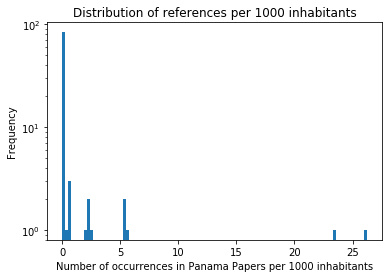

In [32]:
pp_total_country_normalized['counts_normalized_population'].plot.hist(title='Distribution of references per 1000 inhabitants', bins=100, logy=True)
plt.xlabel('Number of occurrences in Panama Papers per 1000 inhabitants')
plt.show()

If we again look at the table with the highest occurrence to population ratio, we can see which countries were involved:

In [33]:
pp_total_country_normalized[['countries', 'counts_normalized_population']].sort_values('counts_normalized_population', ascending=False).head(5)

,countries,counts_normalized_population
62,Seychelles,26.215261
6,Luxembourg,23.337330
16,Cyprus,5.558405
3,Panama,5.489774
1,Switzerland,5.299653


We observe that a large majority of countries are almost not cited in Panama Papers (relative to the population size). The rest of the countries have fewer than 40 references per 1000 in habitants, and there is one extreme outlier with 418 references per 1000 inhabitants. This odd distribution is probably due to the fact there were a few countries that were extremely involved, while the vast majority was simply a small percentage of the extremely rich population that was participating in this scandal.

But let us now try to provide a better visualization of this results, to see if we can understand how they are distributed.

### 2.2 Panama Papers intermediaries

So far we looked at how the number of occurrences is distributed, but not so much at which countries were involved. Thus we decided to look at 2 additional ways of displaying this data, allowing us a better understanding of who was involved:
- Bar plot
- Choropleth plot

For the Choropleth plot however, we realized that very small countries (for instance, tiny islands commonly known as tax havens) were not visible, even though they were heavily implicated. Thus we decided to instead of using the color to display the number of occurrences, to use markers on the location of those islands, with size proportional to the number of occurrences.

We will start by looking at the total number of occurrences, and then look at the number occurrences to population ratio:

In [34]:
def plot_map(df, col_value, limits, title, filename=None, save=False, size=10, sizemin=1):
    """ 
    Utility function to add world map plot using markers, divided into separate groups
    """
    df = df[df[col_value].notnull()].sort_values(col_value, ascending=False)
    
    data = []
    max_v = df[col_value].max()
    
    for i in range(len(limits)):
        lim = limits[i]
        df_sub = df[lim[0]:lim[1]]
        data.append(go.Scattergeo(
                lon = df_sub['long'],
                lat = df_sub['lat'],
                text = df_sub['countries'].astype(str) + " : " + df_sub[col_value].astype(str),
                showlegend = True,
                geo = 'geo2',
                marker = dict(
                    size = df_sub[col_value],
                    sizeref=2. * max_v / (size ** 2),
                    line = dict(width = 0),
                    sizemin=sizemin,
                ),
                name='{0:.2f} - {1:.2f}'.format( df_sub.iloc[-1][col_value], df_sub.iloc[0][col_value]),
        ))


    layout = dict(
        title = title,
        autorange=True,
        scrollzoom=True,
        geo2 = dict(
            showcountries = True,
            countrycolor = "rgb(217, 217, 217)",
            showframe = True,
            resolution=1,
            legend=True,
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5,
            showcoastlines = True,
            projection = dict(
                type = 'Mercator'
            ),
            bgcolor = 'rgba(255, 255, 255, 0.0)',
        )
    )

    fig = dict( data=data, layout=layout)

    iplot( fig, validate=False)
    if save:
        plot( fig, validate=False, filename='../TrovatelliT.github.io/ressources/' + filename, auto_open=False)

#### Number of occurrences

In [35]:
sorted_data = pp_total_country[['countries','total']].sort_values('total', ascending=False).head(15)

data = [go.Bar(
            x=sorted_data['countries'],
            y=sorted_data['total'],
    )]


layout = go.Layout(
    title='Number of occurrences',
)

fig = go.Figure(data=data, layout=layout)
plot(fig, filename='../TrovatelliT.github.io/ressources/bar_occurrences', auto_open=False)
iplot(fig, filename='bar_occurences')


/Users/Timothy/anaconda3/envs/ada/lib/python3.6/site-packages/plotly/offline/offline.py:608: UserWarning:

Your filename `../TrovatelliT.github.io/ressources/bar_occurrences` didn't end with .html. Adding .html to the end of your file.



In [36]:
limits = [(0,2),(3,10),(11,20),(21,50),(50,len(pp_total_country))]
plot_map(pp_total_country, 'total', limits, 'Number of occurrences','map_occurrences',size=10, sizemin=1.5)

There are a few countries that clearly standout, but let us just look at the top 5: Hong Kong, Switzerland, China, Panama and United Kingdom.

The first two are more or less expected. According to many reports, Hong Kong is often used by Chinese Businessmen to hide their money, and given the size of the Chinese population and their position the ranking, this is somewhat expected. Along the same line, Switzerland is known for its banks and banking secrecy, and was historically used by the rich and famous to avoid paying taxes. So again, this result was predictable.

China appears as well, and this is more or less expected due to their population size and levels of corruption.

The last two are the most interesting. Panama is generally perceived as a tax haven, but still not anywhere the level other more known tax havens such as Cayman Islands or Luxembourg. But their presence in this top 5 is easily explained by the fact Mossack Fonseca, the company responsible for creating the majority of the shell companies used in this scandal, was a Panamese company. But it also had large links with the UK and other Commonwealth regions, which explains the UK high position as well.

Other then this specific examples, we seem to see a combination of very populated countries and tax havens. But of course, it's expected that more populated countries will have a larger number of occurrences. So we will now look at the occurrences to population ratio.

#### Number of occurrences per capita

In [37]:
sorted_data = pp_total_country_normalized[['countries','counts_normalized_population']].sort_values('counts_normalized_population', ascending=False).head(15)

data = [go.Bar(
            x=sorted_data['countries'],
            y=sorted_data['counts_normalized_population'],
    )]


layout = go.Layout(
    title='Number of occurrences per capita',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='../TrovatelliT.github.io/ressources/bar_occurrences_per_hab')
plot(fig, filename='../TrovatelliT.github.io/ressources/bar_occurrences_per_hab', auto_open=False)


/Users/Timothy/anaconda3/envs/ada/lib/python3.6/site-packages/plotly/offline/offline.py:608: UserWarning:

Your filename `../TrovatelliT.github.io/ressources/bar_occurrences_per_hab` didn't end with .html. Adding .html to the end of your file.



'file:///Users/Timothy/Documents/Programmation/Applied Data Analysis/ada-project/TrovatelliT.github.io/ressources/bar_occurrences_per_hab.html'

In [38]:
plot_map(pp_total_country_normalized, 'counts_normalized_population', limits, 'Number of occurrences per capita', 'map_occurrences_per_hab', size=10, sizemin=1.5)

This plots show a much different picture. We see that almost all of the countries mentioned are countries which are typically known as "tax-havens", such as Seychelles, Cayman and Bermuda. We see however that all of them are dwarfed by the British Virgin Islands. This again matches the [reports](http://www.independent.com.mt/articles/2016-04-18/world-news/Panama-Papers-Tiny-British-Virgin-Islands-has-big-role-in-leaked-documents-6736156470) about this affair, which indicate the British Virgin Islands was were a large number of the shell companies were created.

But let us also look at the occurrences normalized by income share.

#### Number of occurrences by income share:

In [39]:
sorted_data = pp_total_country_normalized[['countries','counts_normalized_income_share']].sort_values('counts_normalized_income_share', ascending=False).head(15)

data = [go.Bar(
            x=sorted_data['countries'],
            y=sorted_data['counts_normalized_income_share'],
    )]


layout = go.Layout(
    title='Number of occurrences by income share',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='../TrovatelliT.github.io/ressources/occurrences_per_income')
plot(fig, filename='../TrovatelliT.github.io/ressources/occurrences_per_income', auto_open=False)


/Users/Timothy/anaconda3/envs/ada/lib/python3.6/site-packages/plotly/offline/offline.py:608: UserWarning:

Your filename `../TrovatelliT.github.io/ressources/occurrences_per_income` didn't end with .html. Adding .html to the end of your file.



'file:///Users/Timothy/Documents/Programmation/Applied Data Analysis/ada-project/TrovatelliT.github.io/ressources/occurrences_per_income.html'

In [40]:
plot_map(pp_total_country_normalized, 'counts_normalized_income_share', limits, 'Number of occurrences by income share', 'map_occurrences_per_inc', size=10, sizemin=1.5, save=True)

/Users/Timothy/anaconda3/envs/ada/lib/python3.6/site-packages/plotly/offline/offline.py:608: UserWarning:

Your filename `../TrovatelliT.github.io/ressources/map_occurrences_per_inc` didn't end with .html. Adding .html to the end of your file.



(NOT SURE WHAT TO SAY, WE CAN REMOVE IF U WANT)

### Socioeconomic factors 

Now we will try to find a correlation between the amount of involvement in Panama Papers of the three different types of node and different social economic factors. We considered several different socio-economic factors, but ultimately we decided to focus on:
- Human Development Index
- GDP per capita
- Gini coefficient (measures inequality)
- Income share of the 20% richest

In [41]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

We define a simple function to count the number of occurrences of the various entity in the Panama Papers

In [42]:
def count_occurence(pp_data):
    return pp_data.groupby(['country_codes', 'countries']).size().reset_index(name='counts')

We will now use this function to count the number of occurrences of each country in the scandal

In [43]:
pp_references_officier = count_occurence(pp_nodes_officer)
pp_references_officier.sort_values('counts', ascending=False).head(10)

,country_codes,countries,counts
33,CHN,China,24635
75,HKG,Hong Kong,13362
192,VGB,British Virgin Islands,11231
90,JEY,Jersey,6892
142,PAN,Panama,5069
61,GBR,United Kingdom,4914
31,CHE,Switzerland,4268
154,RUS,Russia,4119
183,TWN,Taiwan,3692
188,USA,United States,3612


In [44]:
pp_references_entity = count_occurence(pp_nodes_entity)
pp_references_entity.sort_values('counts', ascending=False).head(10)

,country_codes,countries,counts
59,HKG,Hong Kong,37911
27,CHE,Switzerland,37911
114,PAN,Panama,15811
73,JEY,Jersey,14331
89,LUX,Luxembourg,10840
51,GBR,United Kingdom,9619
53,GGY,Guernsey,7327
5,ARE,United Arab Emirates,7269
16,BHS,Bahamas,4984
145,URY,Uruguay,4906


In [45]:
pp_references_intermediary = count_occurence(pp_nodes_intermediary)
pp_references_intermediary.sort_values('counts', ascending=False).head(9)

,country_codes,countries,counts
91,HKG,Hong Kong,2202
75,GBR,United Kingdom,1367
28,CHE,Switzerland,1218
217,USA,United States,603
161,PAN,Panama,552
90,GTM,Guatemala,441
24,BRA,Brazil,399
132,LUX,Luxembourg,398
65,ECU,Ecuador,323


As we can see, most of the countries with high presence in the panama papers are either countries known to have non strict fiscal laws either country with a very high population. We will later normalize by the population of each country to delete the bias that comes from the population size.

We might be also interested by the total number of occurrences in the Panama papers regardless of the the type of node. Let's compute it:

In [46]:
pp_references_total = pp_references_intermediary.merge(pp_references_entity, on='country_codes')
pp_references_total = pp_references_total.merge(pp_references_officier, on='country_codes')
pp_references_total['counts'] = pp_references_total['counts'] + pp_references_total['counts_x'] + pp_references_total['counts_y']
pp_references_total = pp_references_total[['country_codes', 'countries', 'counts']]


In [47]:
pp_references_total.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
48,HKG,Hong Kong,53475
21,CHE,Switzerland,43397
23,CHN,China,28101
94,PAN,Panama,21432
42,GBR,United Kingdom,15900


We now define the different datasets in which we will try to find a correlation with the social factor 

In [48]:
nodes_types = [pp_references_entity, pp_references_intermediary, pp_references_officier, pp_references_total]
nodes_types_desc = ['Entity references', 'Intermediary references', 'Officier references', 'Total references']


As stated above, the number of occurrences is biased by countries that have a high population. To remove this bias, we want to normalize the counts of occurrences by the population of each country.
The function that we define bellow simply does that.

In [49]:
def normalize_count(df):
    merged = df.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')[['country_codes', 'countries', 'counts', '2014']]
    merged['counts_normalized'] = merged['counts'] / merged['2014']
    return merged

In [50]:
# Normalizing every dataset
nodes_types_normalized = list(map(normalize_count, nodes_types))

### GDP
The GDP per capita is the value of all the goods and services produced by a country in one year. It therefore represents approximately how rich a country is. We chose to use this indicator because we thought that richer people might have more incentive to try to evade the tax system. We will go deeper in this analyze later. 

First, we start by selecting only the GDP per capita of 2015 (year of the affair). We will then merge the GDP dataset with all the datasets of the various type of nodes.

In [51]:
gdp_2015 = un_gdp_per_capita[un_gdp_per_capita['Year'] == 2015][['CODE', 'Value']]
gdp_data = [x.merge(gdp_2015, left_on='country_codes', right_on='CODE') for x in nodes_types_normalized]


We now define a function that will create a scatter plot between an economic index and all the types of nodes. This function will also compute the Pearson and Spearman correlation coefficient and give us the p-value.

In [52]:
def plot_all_entity(data, x_name, y_name, data_name, index_activated, title, x_label, y_label, save_name):
    traces = []
    i = 0
    for d in data:
        # Create a trace
        trace = go.Scatter(
            name = data_name[i],
            x = d[x_name],
            y = d[y_name],
            mode = 'markers',
            text = d['countries'],
            visible = 'legendonly' if i != index_activated else True
        )
        traces.append(trace)
        
        corr, p = stats.pearsonr(d[x_name], d[y_name])
        print(data_name[i])
        print('\tpearson : ', corr, '; p-val: ', p)
        corr, p = stats.spearmanr(d[x_name], d[y_name])
        print('\tspearman : ', corr, '; p-val: ', p)
        i+=1
    data = traces
    
    layout = go.Layout(
        title=title,
        xaxis=dict(
            title=x_label
        ),
        yaxis=dict(
            title=y_label
        ),
        hovermode = 'closest'
    )
    fig = go.Figure(data=data, layout=layout)
    file_path = '../TrovatelliT.github.io/ressources/' + save_name
    iplot(fig)
    plot(fig, filename=file_path, auto_open=False) # Also save the plot for the website


We display the scatter plot showing the correlation between the GDP per capita and the number of total occurrences normalized in the scandal. As said earlier, we will only consider the number of occurrences normalized since countries with high populations will render the number of counts more biased.

In [53]:
plot_all_entity(gdp_data, 'counts_normalized', 'Value', nodes_types_desc, 3, 'GDP per capita vs number of occurrences in the scandal', 'Number of occurrences in the Panama Papers per inhabitant', 'GDP per capita', 'scatter_gdp_count.html')


Entity references
	pearson :  0.6510367995714508 ; p-val:  2.50890788369854e-19
	spearman :  0.6285766629575078 ; p-val:  9.292196238974889e-18
Intermediary references
	pearson :  0.7150706906732729 ; p-val:  1.7554539226167704e-21
	spearman :  0.6451568721451854 ; p-val:  1.553788694580932e-16
Officier references
	pearson :  0.12722984052011616 ; p-val:  0.08187113641492019
	spearman :  0.6855479005810181 ; p-val:  1.9385852679536105e-27
Total references
	pearson :  0.2756285377623522 ; p-val:  0.0016381828103720743
	spearman :  0.5952072010729874 ; p-val:  1.2687783517313314e-13


As we can see most there are a few outliers. Most of them are fiscal paradise that have a high number of occurrences and a low number of population (British Virgin Islands, Luxembourg, Bermuda, etc.). As we're plotting the number of occurrences normalized, we would expect such countries to stand out.

To solve this problem we'll only keep points $x$ that respect these conditions:

$$q_{.25} - 1.5 \cdot \text{IQR} \leq x \leq q_{.75} + 1.5 \cdot \text{IQR}$$

where : 

- $\text{IQR}$ is the interquartile range defined by: $q_{.75} - q_{.25}$
- $q_t$ is the t-quantile of this distribution

From now on, we'll always remove the outliers of every plots

We'll also compute the p-value.
Our null hypothesis $H_0$ is that the two variables are uncorrelated. We can reject $H_0$ when the p-value is high enough. We'll fix our threshold $\alpha = .05$. So if a p-value is higher than $.05$ we can reject the fact that the two variables are uncorrelated.

Below we'll only analyze variables that have a significant correlation.


The function below implement that.

In [54]:
def remove_outliers(data, field1, field2):
    Q1_1 = data[field1].quantile(0.25)
    Q3_1 = data[field1].quantile(0.75)
    IQR_1 = Q3_1 - Q1_1
    
    Q1_2 = data[field2].quantile(0.25)
    Q3_2 = data[field2].quantile(0.75)
    IQR_2 = Q3_2 - Q1_2

    filter1 = (data[field1] < Q3_1 + 1.5 * IQR_1) & (data[field1] > Q1_1 - 1.5 * IQR_1)
    filter2 = (data[field2] < Q3_2 + 1.5 * IQR_2) & (data[field2] > Q1_2 - 1.5 * IQR_2)
    return data[filter1 & filter2]

We'll now plot the same plot without the outliers.

In [55]:
data = list(map(lambda d: remove_outliers(d, 'Value', 'counts_normalized'), gdp_data))
plot_all_entity(data, 'counts_normalized', 'Value', nodes_types_desc, 3, 'GDP per capita vs number of occurrences in the scandal without outliers', 'Number of occurrences in the Panama Papers per inhabitant', 'GDP per capita', 'scatter_gdp_count_outlier.html')


Entity references
	pearson :  0.23129683833119966 ; p-val:  0.012484761903557129
	spearman :  0.6035455417409022 ; p-val:  7.450214102079221e-13
Intermediary references
	pearson :  0.3636282919870751 ; p-val:  0.00014810946790924493
	spearman :  0.6185602756884151 ; p-val:  2.6120917820835085e-12
Officier references
	pearson :  0.4362808144227363 ; p-val:  3.699496314204286e-08
	spearman :  0.6584449099565494 ; p-val:  1.6878406678485969e-19
Total references
	pearson :  0.12165059315598446 ; p-val:  0.23033496857175298
	spearman :  0.5385112508104001 ; p-val:  8.959416567754556e-09


Even if on this graph the correlation are smaller, it is can better see the pattern that the number are suggesting. 
We can see that for the officers the correlation coefficients are very high. The p-values are very small and allow us to reject the fact that the references of officer and the GDP is uncorrelated.


We observe that countries where the GDP is higher appear more often in the Panama Papers. Again, this is what we would intuitively predict.
Richer countries have usually better infrastructure and therefore have a system to ensure that the taxes are actually collected.
This provides a much larger incentive for people to try to evade this systems by any means they can, which leads to scandals such as this one.

### Gini Index

The Gini coefficient measures the inequality in the distribution of wealth in a country (lower coefficient means lower inequality). The most equal equal society is when every person get the same income (When gini = 0). Our initial assumption was that countries in which there is high levels of income inequality would be more heavily involved in this affair, as this is generally heavily linked with corruption and tax evasion.

We do the same as for the GDP. We join the dataset with the Gini coefficients and with the number of occurrences in the scandal. We then only show the plot without the outliers.

In [56]:
gini_data = [x.merge(wb_gini, left_on='country_codes', right_on='Country Code') for x in nodes_types_normalized]

In [57]:
data = list(map(lambda d: remove_outliers(d, 'Gini', 'counts_normalized'), gini_data))
plot_all_entity(data, 'counts_normalized', 'Gini', nodes_types_desc, 3, 'Gini coefficient vs number of occurrenes in the scandal without outliers', 'Number of occurrences per inhabitant', 'Gini Index', 'scatter_gini_count_outlier.html')

Entity references
	pearson :  0.022208972975518916 ; p-val:  0.834481706699075
	spearman :  -0.06677284496632857 ; p-val:  0.5294345944306046
Intermediary references
	pearson :  -0.04743163124534681 ; p-val:  0.6741300964898189
	spearman :  -0.08680628118265445 ; p-val:  0.44096197801827186
Officier references
	pearson :  -0.02830459460806839 ; p-val:  0.7579450080938033
	spearman :  -0.06955325908506865 ; p-val:  0.4484133031891383
Total references
	pearson :  -0.027051310386034675 ; p-val:  0.8177976273022307
	spearman :  -0.09558222096389055 ; p-val:  0.41465273285911763


As we can see in the table above, the correlation between the number of occurrence and the Gini coefficient is not really relevant as the high p-value suggests.

We can then not reject the hypothesis $H_0$ that the two variables are uncorrelated.

Which is surprising !
Our initial assumption was that countries in which there is high levels of income inequality would be more heavily involved in this affair. As the tax evasion are higher in those countries, the redistribution of wealth is reduced.



### Income held by top 20%

This index also measures inequality but it quantifies it differently by expressing the share of wealth held to the top 20% richest. We would expect similar results as for the Gini coefficient since both indices are measuring inequality.

We'll again show the plot without the outliers.

In [58]:
income_share_data = [x.merge(wb_income_share_20_per, left_on='country_codes', right_on='Country Code') for x in nodes_types_normalized]


In [59]:
data = list(map(lambda d: remove_outliers(d, 'counts_normalized', 'Income Share'), income_share_data))
plot_all_entity(data, 'counts_normalized', 'Income Share', nodes_types_desc, 3, 'Wealth held by 20% richest vs number of occurrences in the scandal', 'Number of occurences per inhabitant', 'Wealth held by 20% richest [%]', 'scatter_20_count_outliers.html')


Entity references
	pearson :  0.020118388348656053 ; p-val:  0.8507113344738853
	spearman :  -0.13089882361978766 ; p-val:  0.21878856713695718
Intermediary references
	pearson :  -0.08001817692149342 ; p-val:  0.47763587921380724
	spearman :  -0.15917201257475747 ; p-val:  0.1557973105729123
Officier references
	pearson :  -0.03856234382657333 ; p-val:  0.6745300237214964
	spearman :  -0.12611105130829123 ; p-val:  0.168100859743007
Total references
	pearson :  -0.05823303695554936 ; p-val:  0.6197081921442793
	spearman :  -0.17189478411666026 ; p-val:  0.1403066847823988


All the correlation coefficients are low and the p-values are very high. We can again not reject $H_0$.
There is almost no correlation which is coherent with what we observed before for the Gini coefficient.

Unfortunately, we do not get anymore insight by using this metric when studying the involvement of a country in Panama Papers.


### HDI

The HDI index try to represent how well a country is developed by using the lifespan, the education level and the GDP per capita of an average citizen to compute the index.  
We now observe if there is a correlation between the HDI and the number of occurrence in this affair.

As we've done so far, we will show the scatter plot of the HDI vs the number of occurrences in the Panama Papers without the outliers.

In [60]:
hdi_data = [x.merge(un_hdi_components_2014, left_on='country_codes', right_on='CODE') for x in nodes_types_normalized]


In [61]:
data = list(map(lambda d: remove_outliers(d, 'Human Development Index (HDI)', 'counts_normalized'), hdi_data))
plot_all_entity(data, 'counts_normalized', 'Human Development Index (HDI)', nodes_types_desc, 3, 'HDI vs number of occurrences in the scandal', 'Number of occurences per inhabitant', 'HDI Index', 'scatter_hdi_count_outlier.html')


Entity references
	pearson :  0.2408578893332109 ; p-val:  0.011639242465805177
	spearman :  0.5308067635418598 ; p-val:  2.898835128865019e-09
Intermediary references
	pearson :  0.30928860299877114 ; p-val:  0.0019425894839390943
	spearman :  0.5196789149636303 ; p-val:  4.171432225610701e-08
Officier references
	pearson :  0.45587227382986545 ; p-val:  6.543257709460018e-09
	spearman :  0.6205223819031734 ; p-val:  5.177718075083676e-17
Total references
	pearson :  0.23480729070912107 ; p-val:  0.021995627233654214
	spearman :  0.48046530551766936 ; p-val:  8.324509404392334e-07


The p-value suggest that we can reject $H_0$, therefore the variables are correlated. This is map were we can best visually see the correlation. It seems that for an $\text{HDI} \geq 0.65$ there is a big increase in the number of occurrences in the Panama Papers.

There seems to be a correlation as the plot and the Spearman coefficient suggest.
One of the reasons could be that a country with higher HDI have generally a better infrastructures to ensure that the tax are paid. Additionally, a country with higher HDI is home to richer people since the GDP per capita is also taken into account in the calculation of the HDI. Or maybe it is the case because richer people like to live in developed country? 

In this section we studied the impact of socioeconomic factor in the way countries are involved in the Panama papers. We saw that we couldn't show that the degree of inequality within a country influenced how tied to this affair a country was. However we saw that there is a medium a correlation with the GDP per capita and with the HDI as well.